In [27]:
import pandas as pd
import numpy as np
from scipy import stats as sp
import sys, os
sys.path.append('../')
import trace_analysis
import plots_analysis
import trace_statistics
import trace_classification
import csv
import warnings 
warnings.filterwarnings('ignore')

# Data Preparation


Prepare the data to be used with kNN

In [2]:
plots = set()
with open('traces/traces.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
            continue
        else:
            plots.add((row[1], row[2]))

plots = list(plots)  

stats = None
win_25_stats = None
win_50_stats = None
win_100_stats = None

for row in plots:
    label = 'Normal'
    experiment = row[1]
    
    # Assign a label
    if row[1].find('gh') >= 0 or row[1].find('bh') >= 0:
        label = 'Attacked'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)
        win_25_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)
        win_50_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)
        win_100_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)
    else:
        stats = pd.concat([stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)])
        win_25_stats = pd.concat([win_25_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)])
        win_50_stats = pd.concat([win_50_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)])
        win_100_stats = pd.concat([win_100_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)])
        
stats = stats.reset_index(drop=True)
win_25_stats = win_25_stats.reset_index(drop=True)
win_50_stats = win_50_stats.reset_index(drop=True)
win_100_stats = win_100_stats.reset_index(drop=True)

# Create a dictionary containing all the statistics for each trace size
trace_stats = {200: stats, 25: win_25_stats, 50: win_50_stats, 100: win_100_stats}
stats.head(5)

,node_id,experiment,count,mean,var,std,hop,min,max,loss,outliers,label
0,aaaa::212:7404:4:404:,grid_1gh-9_2019-02-15_19:19_,186,102.369355,5317.077813,72.918295,2,52.7,582.0,0.070,6,Attacked
1,aaaa::212:7405:5:505:,grid_1gh-9_2019-02-15_19:19_,109,179.700000,7535.613519,86.807912,3,83.1,522.0,0.455,5,Attacked
2,aaaa::212:7402:2:202:,grid_1gh-9_2019-02-15_19:19_,120,117.465000,5047.521118,71.045909,2,48.4,374.0,0.400,6,Attacked
3,aaaa::212:740a:a:a0a:,grid_1gh-9_2019-02-15_19:19_,99,215.575758,7842.838590,88.559802,4,143.0,611.0,0.505,5,Attacked
4,aaaa::212:7409:9:909:,grid_1gh-9_2019-02-15_19:19_,171,201.941520,8513.949501,92.271065,3,112.0,694.0,0.145,11,Attacked


Stats for single network

In [3]:
net_stats = trace_statistics.compute_labeled_statistics_by_network(stats, 'loss', 9)
net_win_25_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_25_stats, 'loss', 9, 25)
net_win_50_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_50_stats, 'loss', 9, 50)
net_win_100_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_100_stats, 'loss', 9, 100)

# Create a dictionary containing all the statistics for each trace size
network_stats = {200: net_stats, 25: net_win_25_stats, 50: net_win_50_stats, 100: net_win_100_stats}
net_stats.head(5)

,experiment,label,1,2,3,4,5,6,7,8,9
0,grid9_1bh-3_2019-02-13_16:28_,Attacked,0.070,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18
1,grid9_1bh-3_2019-02-13_22:05_,Attacked,0.045,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18
2,grid9_1bh-5_2019-02-13_15:31_,Attacked,0.040,7.500000e-02,1.900000e-01,2.000000e-02,2.450000e-01,8.500000e-02,9.500000e-02,1.900000e-01,1.450000e-01
3,grid9_1bh-5_2019-02-13_21:44_,Attacked,0.115,1.600000e-01,2.000000e-02,3.000000e-02,2.100000e-01,1.750000e-01,9.000000e-02,7.500000e-02,1.350000e-01
4,grid9_1bh-6_2019-02-13_12:59_,Attacked,0.080,1.650000e-01,1.000000e-01,2.050000e-01,4.000000e-02,1.550000e-01,1.000000e-02,1.650000e-01,9.223372e+18


# Feature Selection

Select the set of features and labels that we use to fit the algorithm

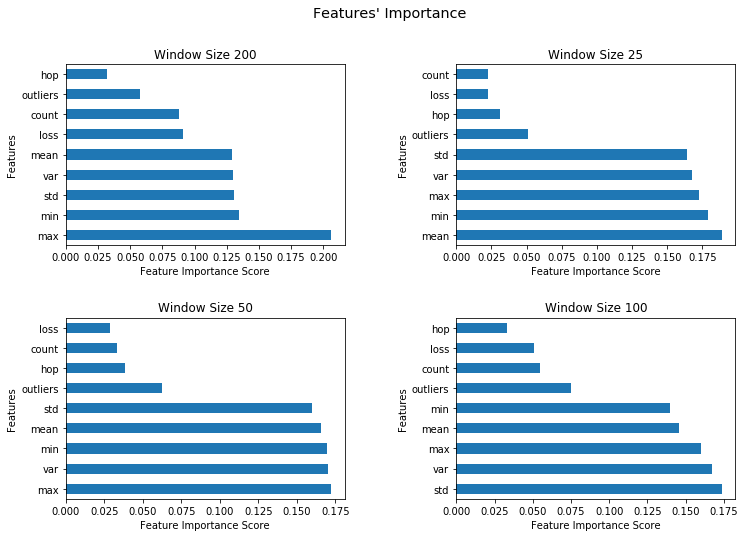

In [4]:
plots_analysis.random_forests_features_selection(trace_stats)

In [5]:
results = None            # Results from each classification algorithm
cv_results = None         # Cross validation results from each classification algorithm
net_results = None            # Results from each classification algorithm
cv_net_results = None         # Cross validation results from each classification algorithm

features_to_drop = ['node_id', 'experiment', 'label', 'hop', 'loss', 'count', 'outliers']
net_features_to_drop = ['experiment', 'label']

# Random Forests Classifier

Let us experiment with random forests. First, let us select most relevant features.

In [6]:
results = pd.concat([results, 
                     trace_classification.random_forest_classification(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [7]:
cv_results = pd.concat([cv_results, 
                     trace_classification.random_forest_cross_validation(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [28]:
net_results = pd.concat([net_results, 
                     trace_classification.random_forest_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [9]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.random_forest_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# K-Nearest Neighbor (KNN) Classification

Let us first observe the accuracies for different values of k

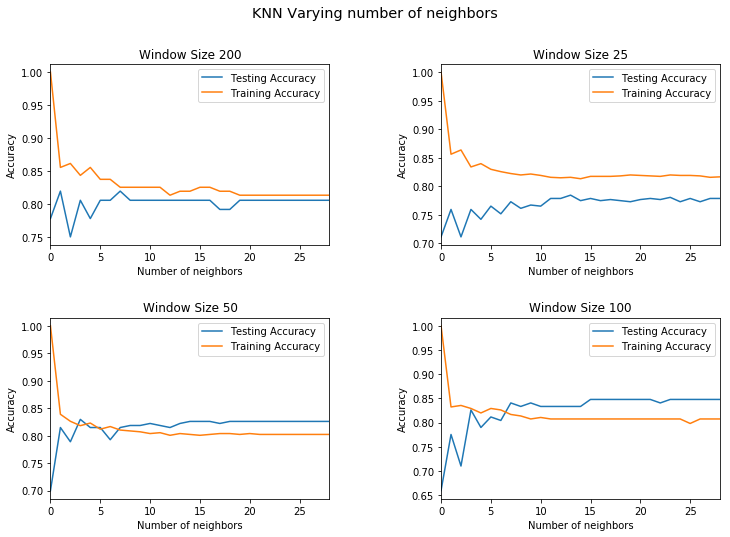

In [10]:
plots_analysis.knn_test_number_of_neighbors(trace_stats, 30)

Let's build KNN classifier 

In [11]:
results = pd.concat([results, 
                     trace_classification.k_nearest_neighbor_classification(trace_stats, features_to_drop, n_neighbors=11)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [12]:
cv_results = pd.concat([cv_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(trace_stats, features_to_drop, n_neighbors=11)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [29]:
net_results = pd.concat([net_results, 
                     trace_classification.k_nearest_neighbor_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [14]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Support Vector Machines (SVM) Classification

Let us experiment with another classifier

In [30]:
results = pd.concat([results, 
                     trace_classification.support_vector_machines_classification(trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [16]:
cv_results = pd.concat([cv_results, 
                     trace_classification.support_vector_machines_cross_validation(trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [31]:
net_results = pd.concat([net_results, 
                     trace_classification.support_vector_machines_classification(network_stats, net_features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [18]:
'''
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.support_vector_machines_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])
'''

'\ncv_net_results = pd.concat([cv_net_results, \n                     trace_classification.support_vector_machines_cross_validation(network_stats, net_features_to_drop, cross_val=3)\n                    ])\n'

# One Vs The Rest Classifier

SVM performs really well, but it is slow. Now we try to implement it in a most efficient way. The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes

In [32]:
results = pd.concat([results, 
                     trace_classification.ensalble_svm_classification(trace_stats, features_to_drop, n_estimators=15)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validate

In [33]:
cv_results = pd.concat([cv_results, 
                     trace_classification.ensalble_svm_cross_validation(trace_stats, features_to_drop, n_estimators=15)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [34]:
net_results = pd.concat([net_results, 
                     trace_classification.ensalble_svm_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [35]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.ensalble_svm_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Per Node Results

Results from each model

In [23]:
results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.763889,0.550549,0.528325,0.526132,0.088880,0.010382
1,Random Forest,25,0.763462,0.565261,0.515918,0.489296,0.232175,0.011762
2,Random Forest,50,0.807407,0.620000,0.556306,0.562562,0.149102,0.008999
3,Random Forest,100,0.804348,0.581846,0.552116,0.558269,0.118608,0.007955
4,KNN,200,0.805556,0.661765,0.554187,0.555556,0.002322,0.004973
5,KNN,25,0.767308,0.604360,0.533757,0.520686,0.001810,0.014775
6,KNN,50,0.822222,0.667308,0.540822,0.536414,0.001195,0.008216
7,KNN,100,0.833333,0.641767,0.550940,0.556890,0.001085,0.004713
8,SVM,200,0.805556,0.402778,0.500000,0.446154,0.002267,0.000857
9,SVM,25,0.775000,0.388247,0.498762,0.436620,0.036010,0.006511


Here we plot the average results for each model computed with cross validation

In [24]:
cv_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.768794
1,Random Forest,25,0.761971
2,Random Forest,50,0.770348
3,Random Forest,100,0.750000
4,KNN,200,0.789628
5,KNN,25,0.782757
6,KNN,50,0.792657
7,KNN,100,0.789130
8,SVM,200,0.806649
9,SVM,25,0.800115


# Network Results

Here we print the results from each model on the whole network

In [25]:
net_results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.888889,0.444444,0.5000,0.470588,0.087240,0.006499
1,Random Forest,25,0.777778,0.388889,0.5000,0.437500,0.071328,0.009852
2,Random Forest,50,0.750000,0.409091,0.4500,0.428571,0.095303,0.006577
3,Random Forest,100,0.833333,0.416667,0.5000,0.454545,0.069689,0.010828
4,KNN,200,0.666667,0.625000,0.8125,0.584615,0.002054,0.001967
5,KNN,25,0.777778,0.388889,0.5000,0.437500,0.001327,0.004076
6,KNN,50,0.833333,0.416667,0.5000,0.454545,0.000960,0.001899
7,KNN,100,0.833333,0.416667,0.5000,0.454545,0.000864,0.001449
8,SVM,200,0.888889,0.444444,0.5000,0.470588,0.001850,0.000941
9,SVM,25,0.777778,0.388889,0.5000,0.437500,0.001079,0.000684


Here we plot the average results for each model computed with cross validation

In [26]:
cv_net_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.765320
1,Random Forest,25,0.829148
2,Random Forest,50,0.792407
3,Random Forest,100,0.784586
4,KNN,200,0.728283
5,KNN,25,0.712535
6,KNN,50,0.670872
7,KNN,100,0.786257
8,OneVsRestClassifier (SVM),200,0.835690
9,OneVsRestClassifier (SVM),25,0.708882
